<a href="https://colab.research.google.com/github/nikhith-nikky/Projects/blob/master/CNN_emotion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [27]:
import keras
from keras import regularizers
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential, Model, model_from_json
from keras.layers import Dense, Embedding, LSTM
from keras.layers import Input, Flatten, Dropout, Activation, BatchNormalization
from keras.layers import Conv1D, MaxPooling1D, AveragePooling1D
from keras.callbacks import ModelCheckpoint
from keras.utils import np_utils, to_categorical

In [25]:
import os
import glob
import librosa
import librosa.display
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import IPython.display as ipd
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.preprocessing import LabelEncoder

In [1]:
from google.colab import files
files.upload()

Saving speech-emotion-recognition-ravdess-data.zip to speech-emotion-recognition-ravdess-data.zip


In [3]:
emotions={
  '01':'neutral',
  '02':'calm',
  '03':'happy',
  '04':'sad',
  '05':'angry',
  '06':'fearful',
  '07':'disgust',
  '08':'surprised'
}

In [8]:
import zipfile
with zipfile.ZipFile("speech-emotion-recognition-ravdess-data.zip",'r') as zip_ref:
  zip_ref.extractall("./")

In [11]:
gender=[]
emotion=[]
for file in glob.glob("./Actor_*/*.wav"):
        file_name=os.path.basename(file)
        temp=emotions[file_name.split("-")[2]]
        emotion.append(temp)
        temp=int(file_name.split("-")[5])
        if temp%2 == 0:
            temp="female"
        else:
            temp="male"
        gender.append(temp)

In [12]:
temp1=pd.DataFrame(emotion)
temp2=pd.DataFrame(gender)
df=pd.concat([temp2,temp1],axis=1)

In [13]:
df.columns=['gender','emotion']
df['gender_emotion'] =df.gender + '_' + df.emotion

In [14]:
df.head()

,gender,emotion,gender_emotion
0,female,sad,female_sad
1,male,surprised,male_surprised
2,female,happy,female_happy
3,male,fearful,male_fearful
4,male,surprised,male_surprised


In [15]:
features=[]
for file in glob.glob("./Actor_*/*.wav"):
    voice,sr = librosa.load(file)
    temp=np.array([])
    mfcc = np.mean(librosa.feature.mfcc(y=voice, sr=sr, n_mfcc=40),axis=1)
    temp=np.hstack((temp, mfcc))
    mel=np.mean(librosa.feature.melspectrogram(y=voice, sr=sr),axis=1)
    temp=np.hstack((temp, mel))
    features.append(temp)

In [42]:
X= pd.DataFrame(features)
X.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167
0,-701.934806,93.920178,-5.705951,29.402926,4.478336,7.083843,-6.037792,-5.169330,-6.202500,1.607169,-2.926157,-1.764756,6.520222,-4.497785,3.333982,0.980146,-4.285536,-1.080494,2.809409,-2.591560,-2.292568,-2.097993,-2.556451,-2.103311,-3.144414,2.419342,-1.504820,2.051309,0.089854,-1.550605,-0.815360,-1.291345,1.108775,-0.774235,1.869052,-2.469198,-2.472769,-2.692550,-2.150854,0.353544,...,0.000047,0.000049,0.000035,0.000019,0.000012,0.000008,0.000004,0.000002,0.000004,0.000004,0.000005,0.000005,0.000007,0.000004,0.000011,0.000012,0.000015,0.000016,0.000010,0.000004,0.000001,8.428449e-07,0.000002,0.000005,0.000004,0.000003,7.463104e-07,2.407892e-08,9.941043e-11,2.570203e-15,3.702540e-17,3.308315e-17,3.841470e-17,4.152853e-17,3.476293e-17,3.741748e-17,4.070606e-17,3.725410e-17,3.741310e-17,3.540679e-17
1,-509.643800,71.611764,-17.732268,27.326140,-15.152536,3.238639,-20.055895,-2.476088,-11.146247,-2.992986,-3.823755,-5.954803,2.054737,-11.330991,0.580371,-5.356775,-0.393197,-2.557005,-1.356260,-5.325154,-2.140922,2.041339,-0.546291,6.253925,1.855065,5.773589,2.841066,6.751002,3.080221,2.787953,5.826419,2.395029,5.951149,4.526485,5.810733,1.299648,0.875627,0.203052,3.430757,4.834116,...,0.002024,0.001432,0.000794,0.000596,0.000518,0.000688,0.000709,0.000851,0.001161,0.001004,0.000824,0.002092,0.001275,0.000723,0.000511,0.000731,0.000813,0.000821,0.000515,0.000525,0.000521,5.074210e-04,0.000575,0.000843,0.001051,0.000404,1.071133e-04,8.561208e-06,4.556670e-08,4.083005e-11,3.667645e-11,3.442366e-11,3.268671e-11,3.136854e-11,3.030672e-11,2.945540e-11,2.880302e-11,2.829789e-11,2.795456e-11,2.773329e-11
2,-465.774043,68.223606,-29.941909,22.436082,-5.399721,1.077440,-25.241690,1.840814,-10.404770,0.041337,-2.059205,-6.976910,7.625200,-9.138299,5.146549,-3.806494,-5.873049,-1.847673,-1.161273,-3.274611,-4.635052,-0.977737,-0.931853,1.387096,5.792863,12.220302,11.240365,14.417686,7.352176,6.538431,4.999301,3.230802,3.803360,3.902253,6.572277,0.347732,2.461149,0.534151,2.327203,1.763952,...,0.006928,0.004587,0.009723,0.003310,0.007313,0.001691,0.001008,0.000466,0.000485,0.000462,0.000898,0.001123,0.001192,0.002352,0.003290,0.004642,0.005582,0.007094,0.004082,0.002536,0.002092,2.237035e-03,0.001919,0.002604,0.004034,0.002131,3.547832e-04,1.865838e-05,7.468375e-08,3.679832e-11,3.302367e-11,3.131735e-11,2.985999e-11,2.868322e-11,2.769459e-11,2.687981e-11,2.624331e-11,2.574481e-11,2.540192e-11,2.518115e-11
3,-660.658798,62.918826,-12.880703,22.611771,-4.153881,1.232497,-18.437925,-4.790529,-10.528354,-3.884945,-2.085373,-4.187382,3.176629,-8.323337,2.826863,-3.987963,-4.057986,-1.111740,-0.922414,-2.250787,-7.177169,-2.440907,-2.942264,-2.674202,-2.222098,-0.049345,-0.647937,0.092717,-0.177721,-1.879079,-2.428475,-0.682067,0.561669,2.343415,6.162370,5.008108,5.693231,4.840342,7.201403,8.720730,...,0.000047,0.000065,0.000104,0.000096,0.000105,0.000123,0.000257,0.000186,0.000129,0.000175,0.000245,0.000234,0.000312,0.000137,0.000074,0.000164,0.000280,0.000454,0.000345,0.000305,0.000458,2.602577e-04,0.000134,0.000138,0.000085,0.000030,7.719407e-06,5.846943e-07,3.430087e-09,2.743429e-13,9.000467e-15,6.161978e-15,4.635912e-15,3.715634e-15,3.121051e-15,2.728762e-15,2.461154e-15,2.279430e-15,2.150653e-15,2.084325e-15
4,-539.798676,64.423857,-17.835985,26.165404,-12.949280,1.799088,-21.023412,-4.952345,-9.514455,-4.067247,-7.192747,-4.572911,0.227437,-10.054233,3.555559,-9.409961,-1.713832,-1.449935,-2.608678,-0.019516,-1.206628,0.143856,-0.539920,0.300704,0.112498,5.884107,2.662647,6.237883,2.540719,1.082876,2.003872,1.615486,1.571941,0.723323,4.500034,-0.044985,1.015282,0.999280,3.092323,3.407183,...,0.001541,0.002762,0.004536,0.003702,0.004198,0.002472,0.002791,0.001670,0.0

In [43]:
y= df.iloc[:,[1]]
y.head()

,emotion
0,sad
1,surprised
2,happy
3,fearful
4,surprised


In [44]:
x_train,x_test,y_train,y_test=train_test_split(X, y, test_size=0.25, random_state=0)

In [45]:
x_train

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167
986,-573.695119,34.799589,-22.729313,3.215426,-23.240289,-1.217692,-21.775596,-8.407807,-13.004604,-2.673933,-7.366618,-12.203109,-0.814748,-7.836434,-2.414783,-6.625193,1.532439,-1.856848,0.985953,0.391649,1.318873,3.039801,-0.091952,1.541409,-3.796306,1.750292,-1.180743,0.825909,0.104487,-0.117894,0.164263,-0.868397,1.574474,-0.711108,2.155342,0.175880,1.964686,-0.378196,-0.453858,1.898547,...,0.001511,0.001139,0.000718,0.000754,0.000467,0.000441,0.000389,0.000145,0.000158,0.000276,0.000389,0.000328,0.000382,0.000413,0.000419,0.000462,0.000623,0.000585,0.000497,0.000403,0.000471,0.000376,0.000444,0.000308,0.000203,0.000117,0.000033,2.134283e-06,9.387045e-09,6.654700e-13,1.996748e-13,1.815434e-13,1.686066e-13,1.591196e-13,1.519358e-13,1.460668e-13,1.416548e-13,1.383585e-13,1.359489e-13,1.344511e-13
77,-499.871702,48.211738,-24.134610,17.506557,-11.856676,1.233616,-16.717865,-0.199348,-15.206571,-8.078003,0.777137,-7.132926,-3.381644,-5.717859,-2.250450,-5.722805,-1.909183,-8.376081,0.516491,-3.496312,-3.920016,-1.247839,0.425933,4.914120,1.212413,10.741889,4.320959,6.779140,5.335360,3.187181,3.410191,0.631120,4.751631,3.882420,4.780017,0.422672,1.799386,2.114790,4.306317,4.842451,...,0.003140,0.003212,0.005274,0.003549,0.004328,0.004198,0.003407,0.003863,0.003303,0.003877,0.004573,0.007838,0.008568,0.007728,0.005023,0.004128,0.003462,0.001555,0.000871,0.001367,0.002569,0.003450,0.003723,0.003344,0.002880,0.001966,0.000387,1.957756e-05,1.048653e-07,1.536220e-11,7.322484e-12,6.590685e-12,6.023007e-12,5.583312e-12,5.230237e-12,4.948380e-12,4.730454e-12,4.564227e-12,4.448821e-12,4.376956e-12
572,-517.039960,46.267858,-26.896418,8.971521,-16.174125,2.982348,-16.695064,-5.050027,-12.491036,-5.558583,-2.518979,-7.910154,-3.251942,-10.391520,-4.354105,-7.976649,-4.719160,-7.620593,-0.070796,0.155836,0.005068,4.534917,0.588835,-1.996477,-2.547368,4.028416,-0.675328,2.274902,0.526843,-0.605691,2.594347,1.573023,0.318699,-2.429733,-0.449953,-0.014123,2.056368,-0.522237,1.397590,2.260626,...,0.001356,0.001659,0.001236,0.001088,0.002512,0.003497,0.004258,0.004221,0.004455,0.004828,0.005358,0.004670,0.004004,0.004802,0.005105,0.003812,0.003411,0.002811,0.002702,0.003152,0.002467,0.002646,0.004112,0.001973,0.002675,0.002675,0.001079,2.688238e-05,1.192681e-07,2.974008e-12,1.228704e-14,8.127657e-15,6.017121e-15,4.791393e-15,5.052948e-15,4.626269e-15,4.513797e-15,4.757066e-15,4.996075e-15,4.650026e-15
381,-543.065547,59.766280,-36.003889,19.118348,-9.615210,0.898751,-9.033241,-12.728696,-7.031999,-2.825873,-7.804276,-8.692512,-0.771588,-2.470115,3.087296,-2.450319,-2.000025,1.562972,7.948737,8.198643,6.575888,6.153196,5.811126,9.825857,5.594243,5.026489,1.141746,2.704074,4.824277,3.134319,2.827667,1.661499,3.461796,3.809028,5.083869,3.847178,3.546949,1.402497,1.156064,2.354586,...,0.000822,0.000723,0.000580,0.000466,0.000718,0.000489,0.000244,0.000402,0.000286,0.000184,0.000172,0.000190,0.000178,0.000148,0.000149,0.000170,0.000130,0.000159,0.000153,0.000208,0.000107,0.000135,0.000110,0.000056,0.000043,0.000023,0.000008,5.091412e-07,1.240316e-09,2.400818e-12,2.230113e-12,2.156679e-12,2.089673e-12,2.032550e-12,1.981005e-12,1.935942e-12,1.899480e-12,1.869830e-12,1.849049e-12,1.835285e-12
44,-659.385433,81.647163,-8.747837,27.170506,-2.372558,8.509927,-17.528282,-4.989697,-5.320257,-3.628514,-5.446516,-4.088746,2.981421,-9.534509,-0.081844,-3.402859,-4.531502,-2.885562,-1.596599,-6.226953,-4.629288,-2.773884,-4.608536,-4.163110,-4.192621,0.270584,-3.449032,-0.795303,-4.760038,-4.381029,-3.571161,-3.444060,-0.611670,-2.966894,-2.308267,-4.736581,-2.701916,-3.769310,-1.024065,-0.665881,...,0.000051,0.000093,0.000107,0.000188,0.000197,0.000221,0.000294,0.000275,0.000126,0.000112,0

In [46]:
X_train = np.array(x_train)
y_train = np.array(y_train)
X_test = np.array(x_test)
y_test = np.array(y_test)

In [47]:
X_train = np.expand_dims(X_train, axis=2)
X_test = np.expand_dims(X_test, axis=2)
X_train.shape

(1080, 168, 1)

In [48]:
lb = LabelEncoder()
y_train = np_utils.to_categorical(lb.fit_transform(y_train))
y_test = np_utils.to_categorical(lb.fit_transform(y_test))

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_label.py:251: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [50]:
model = Sequential()
model.add(Conv1D(256, 8, padding='same',input_shape=(X_train.shape[1],1)))  # X_train.shape[1] = No. of Columns
model.add(Activation('relu'))
model.add(Conv1D(256, 8, padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))
model.add(MaxPooling1D(pool_size=(8)))
model.add(Conv1D(128, 8, padding='same'))
model.add(Activation('relu'))
model.add(Conv1D(128, 8, padding='same'))
model.add(Activation('relu'))
model.add(Conv1D(128, 8, padding='same'))
model.add(Activation('relu'))
model.add(Conv1D(128, 8, padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))
model.add(MaxPooling1D(pool_size=(8)))
model.add(Conv1D(64, 8, padding='same'))
model.add(Activation('relu'))
model.add(Conv1D(64, 8, padding='same'))
model.add(Activation('relu'))
model.add(Flatten())
model.add(Dense(8)) # Target class number
model.add(Activation('softmax'))
opt = keras.optimizers.rmsprop(lr=0.00001, decay=1e-6)
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_17 (Conv1D)           (None, 168, 256)          2304      
_________________________________________________________________
activation_19 (Activation)   (None, 168, 256)          0         
_________________________________________________________________
conv1d_18 (Conv1D)           (None, 168, 256)          524544    
_________________________________________________________________
batch_normalization_5 (Batch (None, 168, 256)          1024      
_________________________________________________________________
activation_20 (Activation)   (None, 168, 256)          0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 168, 256)          0         
_________________________________________________________________
max_pooling1d_5 (MaxPooling1 (None, 21, 256)          

In [51]:
model.compile(loss='categorical_crossentropy', optimizer=opt,metrics=['accuracy'])
model_history=model.fit(X_train, y_train, batch_size=16, epochs=100, validation_data=(X_test, y_test))

Train on 1080 samples, validate on 360 samples
Epoch 1/100
1080/1080 [==============================] - 21s 19ms/step - loss: 2.0891 - accuracy: 0.1630 - val_loss: 2.0606 - val_accuracy: 0.1306
Epoch 2/100
1080/1080 [==============================] - 20s 18ms/step - loss: 2.0629 - accuracy: 0.1667 - val_loss: 2.0563 - val_accuracy: 0.1333
Epoch 3/100
1080/1080 [==============================] - 20s 18ms/step - loss: 2.0429 - accuracy: 0.1759 - val_loss: 2.0468 - val_accuracy: 0.2139
Epoch 4/100
1080/1080 [==============================] - 20s 18ms/step - loss: 2.0390 - accuracy: 0.1880 - val_loss: 2.0355 - val_accuracy: 0.2306
Epoch 5/100
1080/1080 [==============================] - 20s 18ms/step - loss: 2.0162 - accuracy: 0.2204 - val_loss: 2.0169 - val_accuracy: 0.2306
Epoch 6/100
1080/1080 [==============================] - 20s 18ms/step - loss: 1.9915 - accuracy: 0.2241 - val_loss: 2.0036 - val_accuracy: 0.2528
Epoch 7/100
1080/1080 [==============================] - 20s 18ms/step 

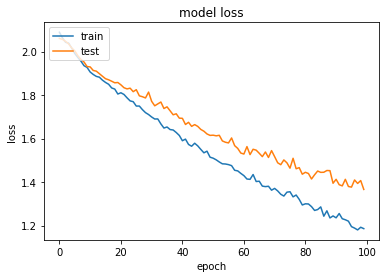

In [52]:
plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()